In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Deliverable 1 — A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion. 

Suppose your work becomes so large that it doesn’t fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead. 

If your project doesn’t fit into Jupyter notebook format (E.g., you built an app that uses ML), write your approach as a report and submit it in a pdf form. 

Deliverable 2 — A public project GitHub repository with your work (please also include the GitHub repo URL in your notebook/report).

Deliverable 3 — A screenshot of your position on the Kaggle competition leaderboard for your top-performing model.

Step 1.
Brief Description of the problem and ddata
Brief description of the problem and data (5 pts) 

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

Step 2.
Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Step 3.
Model Architecture
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

Step 4.
Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Step 5. 
Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Step 6.
Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (35 points)

These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.

If you haven’t used GitHub previously, please find a tutorial and get acquainted with it before the project deadline. For the sake of this project, you can use GitHub to showcase your codebase. In the real world, versioning with GitHub is vital for collaboration. Sometimes Jupyter notebooks don’t seem particularly well-suited to versioning with GitHub due to hard-to-read diffs and the like. If you want to use this project as an opportunity to practice versioning with GitHub, consider something like the following: 

**Part 1: Brief Description of the Problem and Data**
This project uses the kaggle competition dataset https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview. The goal is to use convolutional neural networks (CNN) to identify metastatic cancer in small image patches. The data are RBG images, and the image files are .tif files. The images are of cells that will be labeled cancer or not having cancer, and our job is to perform image classification to predict the labels of the test images.

**Part 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

Load the libraries


In [42]:
import matplotlib.pyplot as plt

import time

import cv2 # For EDA

from PIL import Image

import sys

from numpy.random import seed
seed(101)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
tf.random.set_seed(101)

Load Data

In [43]:
train_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels_df.shape

(220025, 2)

There are a total of 220,025 images in the training set.

Check for duplicate entries

In [44]:
train_labels_df[train_labels_df.duplicated(keep=False)]

,id,label


No duplicates were found!

We will take a look at the distribution of data (cancer vs non-cancerous)

In [ ]:
train_labels_df['label'].value_counts()

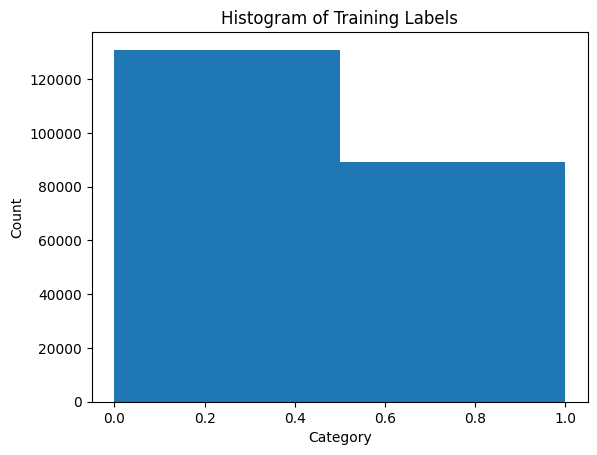

In [45]:
plt.hist(train_labels_df['label'], bins = 2)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Histogram of Training Labels")
plt.show()

The dataset favors non-cancer (0), vs cancer (1) and not too skewed in terms of distribution
Let's take a look at the images and see if there is anything that pops out at us. I highly doubt a visual inspection will help us, as cancer detection is extremely hard to an untrained eye.

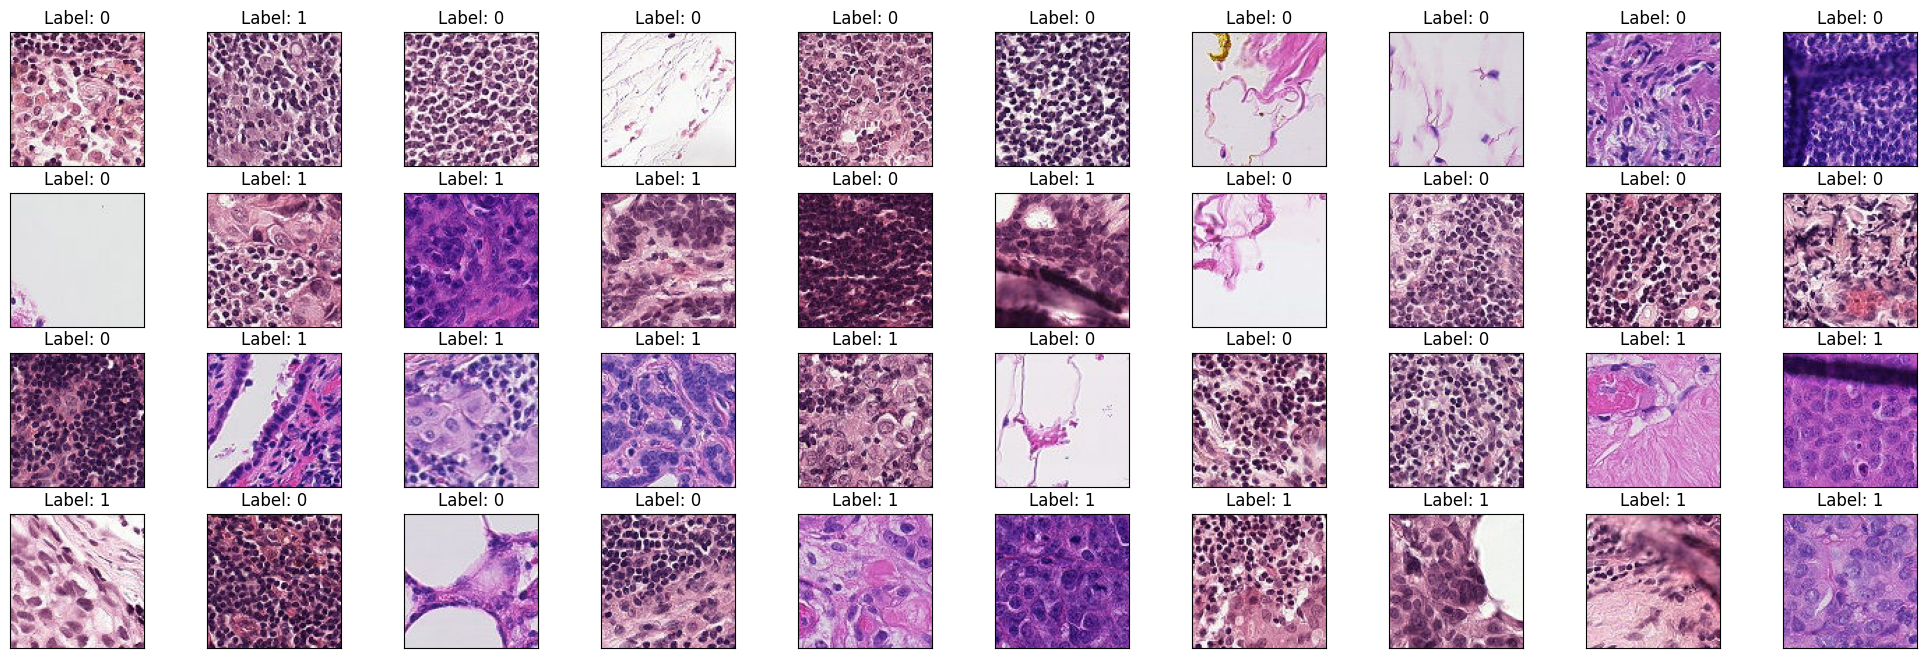

In [46]:
fig = plt.figure(figsize=(25, 8))
train_imgs = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")
for idx, img in enumerate(np.random.choice(train_imgs, 40)):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    im = Image.open("/kaggle/input/histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = train_labels_df.loc[train_labels_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

As expected, there is nothing that is obvious for identifying the cancer.....
Based on our EDA, we found no duplicates an extremely large number of images (220025 for training), and relatively even distribution of classification.
For the analysis and model creation, I plan to lower the sample size drastically for performance purposes so we can do our initial testing/analysis faster.

In [47]:
IMAGE_SIZE=96
IMAGE_CHANNELS=3
SAMPLE_SIZE=2000  

Split 20% of the data to be test data.

In [48]:
df0=train_labels_df[train_labels_df['label']==0].sample(SAMPLE_SIZE,random_state=101)
df1=train_labels_df[train_labels_df['label']==1].sample(SAMPLE_SIZE,random_state=101)
df_data = pd.concat([df0, df1], axis=0) #.reset_index(drop=True)
df_data = shuffle(df_data)
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)
print(df_train.shape)
print(df_val.shape)

(3200, 2)
(800, 2)


Create the directories in the appropriate paths

In [50]:
shutil.rmtree('base_dir')

In [51]:
base_dir='base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
no_cancer = os.path.join(train_dir, 'no_cancer')
os.mkdir(no_cancer)
yes_cancer = os.path.join(train_dir, 'yes_cancer')
os.mkdir(yes_cancer)
no_cancer = os.path.join(val_dir, 'no_cancer')
os.mkdir(no_cancer)
yes_cancer = os.path.join(val_dir, 'yes_cancer')
os.mkdir(yes_cancer)



In [52]:
os.listdir('base_dir/train_dir')

['no_cancer', 'yes_cancer']

In [53]:
df_data.head()

,id,label
8545,7fe038f034c88db3bb93871ffe21e9f4c6ea7c15,1
43566,8a1cde386976cefe9d55005aadf75fd002415e02,1
74002,919c44448bf1531e954e1384e6124c81b0814a01,1
172763,1d2254f93bb23259a66d326e4b757e150b7cb994,1
56242,30be372eb9ac03834c79fca990a2d959eaa08b84,0


Loop thru the images and place them in the created directories

In [54]:
df_data.set_index('id', inplace=True)
train_list = list(df_train['id'])
val_list = list(df_val['id'])
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'no_cancer'
    if target == 1:
        label = 'yes_cancer'
    
    # source path to image
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'no_cancer'
    if target == 1:
        label = 'yes_cancer'
    

    # source path to image
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


Set up the Generators

In [55]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


I referenced this guide with examples for image classification.
https://keras.io/examples/vision/image_classification_from_scratch/
Since we are dealing with single image inputs and single label output, the sequential model is appropriate for a plain stack of layers.
The CNN model has 3 convolution layers with Dense layers.
Block 1:
3 Conv2D layers with 32 filters each
MaxPooling (2×2) to reduce spatial resolution
Dropout (0.3) to prevent overfitting
Block 2:
3 Conv2D layers with 64 filters each
MaxPooling (2×2)
Dropout (0.3)
Block 3:
3 Conv2D layers with 128 filters each
MaxPooling (2×2)
Dropout (0.3)
Classifier:
Flatten layer
Dense (256, ReLU) for high-level feature learning.
Dropout (0.3).
Dense (2, softmax) → outputs probability for two classes (cancer vs. non-cancer)

The early layers with 32 filters capture edges/blobs/textures
The mid-level layers with 64 filters capture shapes and patterns
The Deeper layers with 128 filters capture complex image structures such as tissue, abnormal regions.
Softmax with 2 outputs is suitable for binary classification(no cancer, cancer)
Dense layer with 256 neurons - provides enough capacity to combine feature for final classification without overfitting.
An architecture with fewer convolution layers would train faster, but might underfit if the dataset is large or complex. 

In [56]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
print(val_gen.class_indices)

{'no_cancer': 0, 'yes_cancer': 1}


Since we are just doing initial testing on our model, we have a small sample size and just 10 epochs

In [58]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.5003 - loss: 0.6934 - val_accuracy: 0.7387 - val_loss: 0.6287 - learning_rate: 1.0000e-04
Epoch 2/10
 13/320 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7073 - loss: 0.6052

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7197 - loss: 0.5827 - val_accuracy: 0.7638 - val_loss: 0.5099 - learning_rate: 1.0000e-04
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7665 - loss: 0.5017 - val_accuracy: 0.7638 - val_loss: 0.5036 - learning_rate: 1.0000e-04
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7621 - loss: 0.5031 - val_accuracy: 0.7550 - val_loss: 0.4999 - learning_rate: 1.0000e-04
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7618 - loss: 0.5000 - val_accuracy: 0.7475 - val_loss: 0.5363 - learning_rate: 1.0000e-04
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7652 - loss: 0.4962 - val_accuracy: 0.7775 - val_loss: 0.4942 - learning_rate: 1.0000e-04
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7802 - loss: 0.4731 - val_accuracy: 0.7350 - val_loss: 0.5359 - learning_rate: 1.0000e-04
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.78

In [59]:
model.metrics_names

['loss', 'compile_metrics']

In [60]:
val_loss, val_acc = model.evaluate(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6733 - loss: 0.6401
val_loss: 0.4698665738105774
val_acc: 0.7737500071525574


<Figure size 640x480 with 0 Axes>

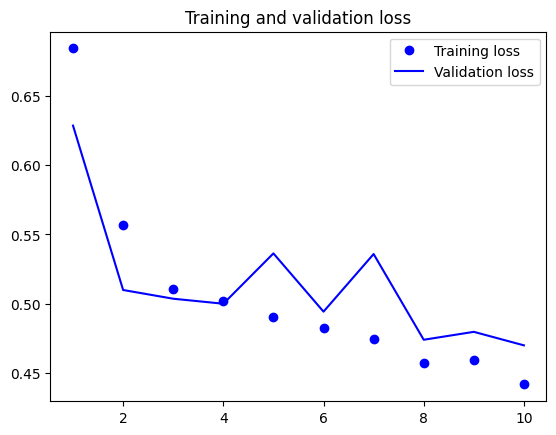

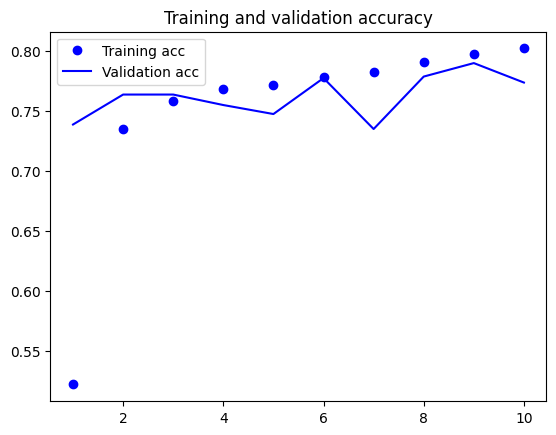

<Figure size 640x480 with 0 Axes>

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [62]:
test_gen.class_indices

{'no_cancer': 0, 'yes_cancer': 1}

In [63]:
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)


800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [64]:
predictions.shape

(800, 2)

In [65]:
df_preds = pd.DataFrame(predictions, columns=['no_cancer', 'yes_cancer'])

df_preds.head()

,no_cancer,yes_cancer
0,0.360336,0.639664
1,0.021466,0.978534
2,0.006131,0.993869
3,0.028686,0.971314
4,0.018831,0.981169


In [66]:
y_true = test_gen.classes

y_pred = df_preds['yes_cancer']
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.8787125

It looks like we have a good model for just using a small portion of the training data.
We will clear the directories and train the model with the larger dataset.
We can also tune the hyperparameters with the larger dataset and find the optimal values.

In [67]:
shutil.rmtree('base_dir')

Below is all just setting up the training and test data with folders. Same as before.

In [68]:
SAMPLE_SIZE=10000
df_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=42)
df1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=42)
df_data = pd.concat([df0, df1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=42, stratify=y)
base_dir='base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
no_cancer = os.path.join(train_dir, 'no_cancer')
os.mkdir(no_cancer)
yes_cancer = os.path.join(train_dir, 'yes_cancer')
os.mkdir(yes_cancer)
no_cancer = os.path.join(val_dir, 'no_cancer')
os.mkdir(no_cancer)
yes_cancer = os.path.join(val_dir, 'yes_cancer')
os.mkdir(yes_cancer)
df_data.set_index('id', inplace=True)
train_list = list(df_train['id'])
val_list = list(df_val['id'])
for image in train_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    if target == 0:
        label = 'no_cancer'
    if target == 1:
        label = 'yes_cancer'
    
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)

for image in val_list:
    
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    
    if target == 0:
        label = 'no_cancer'
    if target == 1:
        label = 'yes_cancer'

    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)

This took about 10 minutes using a Kaggle GPU.
Now, we set up the model.

In [70]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


HyperParameter tuning: Vary the learning rate and find the best model.

In [71]:
learning_rates=[0.0001, 0.001, 0.01]

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]


curr_best_model = (None, 0)
curr_best_history = None
for lr_iter in learning_rates:
    model.compile(Adam(learning_rate=lr_iter), loss='binary_crossentropy', 
              metrics=['accuracy'])
    this_history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)
    if this_history.history["accuracy"][-1] > curr_best_model[1]:
        curr_best_model = (model, this_history.history["accuracy"][-1])
        curr_best_history = this_history.history

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7994 - loss: 0.4398 - val_accuracy: 0.8073 - val_loss: 0.4198 - learning_rate: 1.0000e-04
Epoch 2/20
  13/1600 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8492 - loss: 0.4230

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8130 - loss: 0.4236 - val_accuracy: 0.7855 - val_loss: 0.4491 - learning_rate: 1.0000e-04
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8159 - loss: 0.4212 - val_accuracy: 0.8112 - val_loss: 0.4204 - learning_rate: 1.0000e-04
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8301 - loss: 0.3924 - val_accuracy: 0.8298 - val_loss: 0.3818 - learning_rate: 1.0000e-04
Epoch 5/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8347 - loss: 0.3805 - val_accuracy: 0.8110 - val_loss: 0.4100 - learning_rate: 1.0000e-04
Epoch 6/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8381 - loss: 0.3715 - val_accuracy: 0.8397 - val_loss: 0.3607 - learning_rate: 1.0000e-04
Epoch 7/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8447 - loss: 0.3523 - val_accuracy: 0.8140 - val_loss: 0.4186 - learning_rate: 1.0000e-04
Epoch 8/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/

Save best model for later use if kaggle disconnects

In [75]:
curr_best_model[0].save('/kaggle/working/my_model.h5')


<h1>Part 4: Results and Analysis</h1>
We trained the model and tuned learning rate hyperparameter. We optimized for validation accuracy to find the optimal parameters.

A learning rate of 0.0001 was found to be optimal.
Sometimes we have to start from here and plug in the learning rate instead of referencing curr_best_model if the connection to kaggle is lost.
Skip this next step if the model was trained and connection was not lost to kaggle.
We can fit the model again and show the validation accuracy as well as training loss.

In [100]:
shutil.rmtree('base_dir')

In [101]:
# Set up the generators
SAMPLE_SIZE=10000
df_data = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=42)
df1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=42)
df_data = pd.concat([df0, df1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=42, stratify=y)
base_dir='base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
no_cancer = os.path.join(train_dir, 'no_cancer')
os.mkdir(no_cancer)
yes_cancer = os.path.join(train_dir, 'yes_cancer')
os.mkdir(yes_cancer)
no_cancer = os.path.join(val_dir, 'no_cancer')
os.mkdir(no_cancer)
yes_cancer = os.path.join(val_dir, 'yes_cancer')
os.mkdir(yes_cancer)
df_data.set_index('id', inplace=True)
train_list = list(df_train['id'])
val_list = list(df_val['id'])
for image in train_list:
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    if target == 0:
        label = 'no_cancer'
    if target == 1:
        label = 'yes_cancer'
    
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.copyfile(src, dst)

for image in val_list:
    
    fname = image + '.tif'
    target = df_data.loc[image,'label']
    
    if target == 0:
        label = 'no_cancer'
    if target == 1:
        label = 'yes_cancer'

    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.copyfile(src, dst)
    
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))


model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=20, verbose=1,
                   callbacks=callbacks_list)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.6492 - loss: 0.5999 - val_accuracy: 0.7430 - val_loss: 0.5218 - learning_rate: 1.0000e-04
Epoch 2/20
  19/1600 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7613 - loss: 0.4836

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7755 - loss: 0.4856 - val_accuracy: 0.7770 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7938 - loss: 0.4520 - val_accuracy: 0.7955 - val_loss: 0.4370 - learning_rate: 1.0000e-04
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8012 - loss: 0.4405 - val_accuracy: 0.7928 - val_loss: 0.4336 - learning_rate: 1.0000e-04
Epoch 5/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8149 - loss: 0.4159 - val_accuracy: 0.8210 - val_loss: 0.3938 - learning_rate: 1.0000e-04
Epoch 6/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8319 - loss: 0.3921 - val_accuracy: 0.8225 - val_loss: 0.3983 - learning_rate: 1.0000e-04
Epoch 7/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8279 - loss: 0.3882 - val_accuracy: 0.8255 - val_loss: 0.3982 - learning_rate: 1.0000e-04
Epoch 8/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/

Let's take a look at the results and plot the curves


In [102]:
model.save('/kaggle/working/my_model.h5')


In [103]:
val_loss, val_acc = model.evaluate(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8404 - loss: 0.4014
val_loss: 0.33006277680397034
val_acc: 0.8632500171661377


Display loss and accuracy curves

<Figure size 640x480 with 0 Axes>

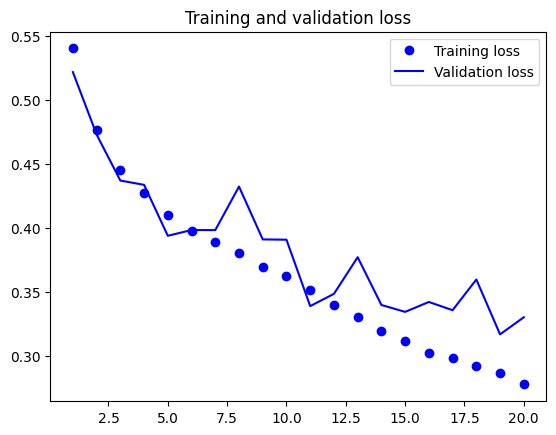

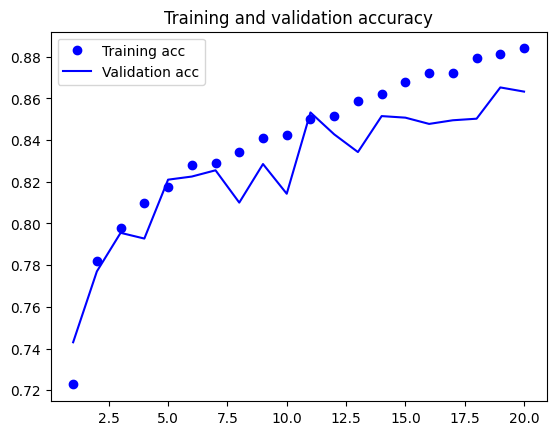

<Figure size 640x480 with 0 Axes>

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

Make predictions

In [105]:
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [106]:
predictions.shape

(4000, 2)

In [107]:
df_preds = pd.DataFrame(predictions, columns=['no_cancer', 'yes_cancer'])

df_preds.head()

,no_cancer,yes_cancer
0,0.738099,0.261901
1,0.994871,0.005128
2,0.998887,0.001113
3,0.180726,0.819274
4,0.995190,0.004810


Let's take a look at the accuracy of predictions

In [108]:
from sklearn.metrics import roc_auc_score
y_true = test_gen.classes
y_pred = df_preds['yes_cancer']
roc_auc_score(y_true, y_pred)

0.945780625

Set up test directory for predictions and submission

In [109]:
shutil.rmtree('base_dir')

Have to get nested directory for keras to work

In [110]:
test_dir = 'test_dir'
os.mkdir(test_dir)
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
os.listdir('test_dir')

test_list = os.listdir('/kaggle/input/histopathologic-cancer-detection/test')

for image in test_list:
    
    fname = image
    
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/test', fname)
    dst = os.path.join(test_images, fname)
    shutil.copyfile(src, dst)

num_test_images=len(os.listdir('test_dir/test_images'))
len(os.listdir('test_dir/test_images'))

57458

In [111]:
num_test_images=len(os.listdir('/kaggle/input/histopathologic-cancer-detection/test'))
len(os.listdir('/kaggle/input/histopathologic-cancer-detection/test'))

57458

Point to correct directory

In [112]:
test_path ='test_dir'
datagen = ImageDataGenerator(rescale=1.0/255)
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(96,96),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [ ]:
#from tensorflow.keras.models import load_model
#import keras
#model = keras.models.load_model('/kaggle/input/modelh5/keras/default/1/my_model.h5')

In [113]:
predictions = model.predict(test_gen, steps=num_test_images, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step


In [114]:
len(predictions)

57458

In [115]:
df_preds = pd.DataFrame(predictions, columns=['no_cancer', 'yes_cancer'])
df_preds.head()

,no_cancer,yes_cancer
0,4.391401e-08,1.000000
1,1.899675e-05,0.999981
2,1.325032e-04,0.999867
3,9.907168e-01,0.009283
4,9.967896e-01,0.003210


Set up format for output document. Extract file name without extension or path

In [117]:
test_filenames = test_gen.filenames
df_preds['file_names'] = test_filenames

In [118]:
def extract_id(x):
    extract_id = x.split('/')[1].split('.')[0]
    return extract_id
test_filenames = test_gen.filenames
submission = pd.DataFrame({'id':df_preds['file_names'].apply(extract_id), 
                           'label':df_preds['yes_cancer'], 
                          }).set_index('id')
submission.head()
submission.to_csv('/kaggle/working/submission.csv')

References:
https://keras.io/examples/vision/image_classification_from_scratch/


Conclusion
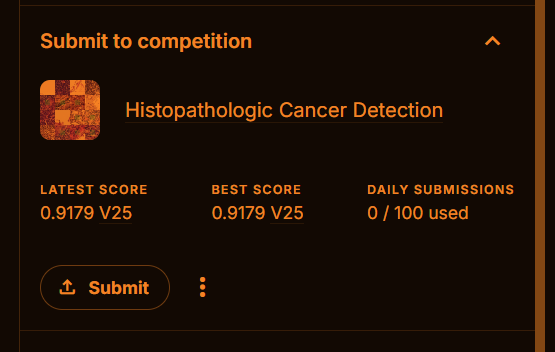

We achieved pretty good results with our prediction! We may have achieved even better results if we trained our data on a larger sample size. We only used 10,000 images for our test/training dataset. We did this to save on resources and we noticed decent accuracy when only using 2,000 images. If resources allowed, I would be interested in tuning other hyperparameters, and adjusting the layers.
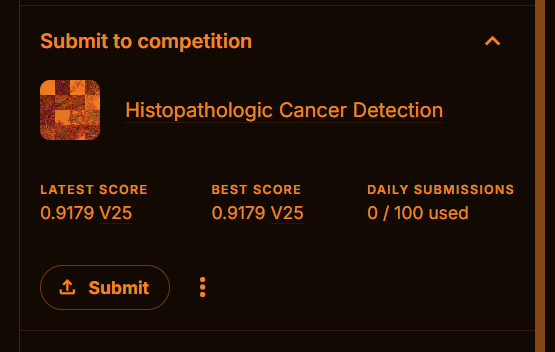